# Diabete Disease Prediction

![diabet.png](image/diabet.png)
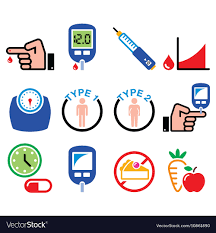

# Table of Contents
- [Business Problem](#1)
- [Dataset story](#2)
- [Data Content](#3)
- [Libraries](#4)
- [Data Preparation](#5)
- [Missing Value Analysis](#6)
- [Missing Value Processing](#7)
- [Outlier Processing](#8)
- [Encoding](#9)
- [Feature Scaling](#10)
- [Modeling](#11)
- [Hyper-parameter optimization](#12)
- [Ensemble Modeling](#13)


<a id="1"></a>
## Business Problem :

*It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified.*

<a id="2"></a>
## Dataset Story

- The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Data used for diabetes research on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city of the State of Arizona in the USA. The target variable is specified as "outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

- Number of variables: 9, Number of observation : 768

<a id='3'></a>
### Data Content

- Pregnancies: Number of pregnancies
- Glucose : 2-hour plasma glucose concentration in the oral glucose tolerance test
- Blood Pressure : Blood Pressure (minor blood pressure) (mm Hg)
- SkinThickness : Skin Thickness
- Insulin: 2-hour serum insulin (mu U/ml)
- DiabetesPedigreeFunction : Function (2-hour plasma glucose concentration in oral glucose tolerance test)
- BMI : Body mass index
- Age : Age (years)
- Outcome : Have the disease (1) or not (0)

<a id='4'></a>
## Libraries 

In this section,we will import necessary libraries

In [1]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns 

import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler,RobustScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.calibration import CalibratedClassifierCV


import lightgbm as lgbm

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

**Alright,We need to auxiliary functions in order to get better coding concept.Let's describe it. :=)**

In [3]:
def load(dataset_path):
    data = pd.read_csv(dataset_path)
    return data

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def plot_importance(model, features, num, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [4]:
diabete=load("input/diabete-disease-dataset.csv")
df=diabete.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [5]:
df.columns=df.columns.str.lower()
df.head()
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: pregnancies, dtype: float64


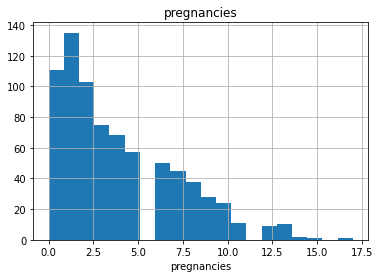

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: glucose, dtype: float64


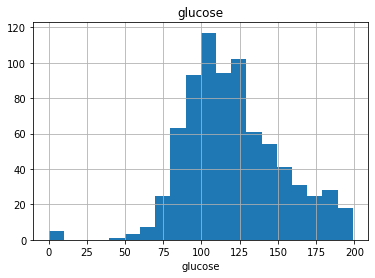

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: bloodpressure, dtype: float64


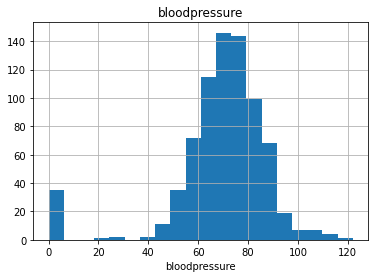

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: skinthickness, dtype: float64


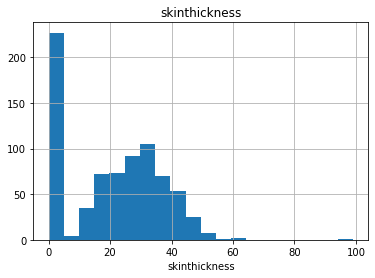

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: insulin, dtype: float64


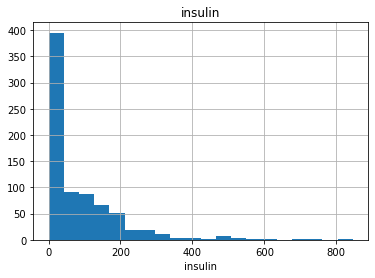

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: bmi, dtype: float64


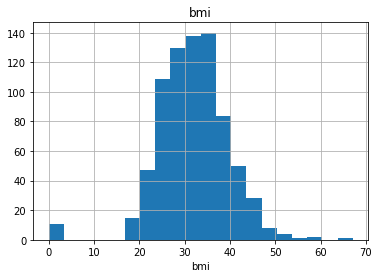

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: diabetespedigreefunction, dtype: float64


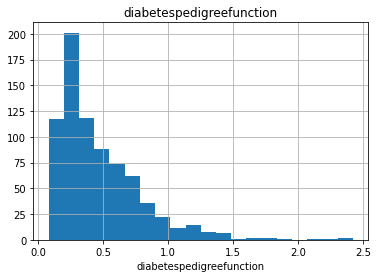

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: age, dtype: float64


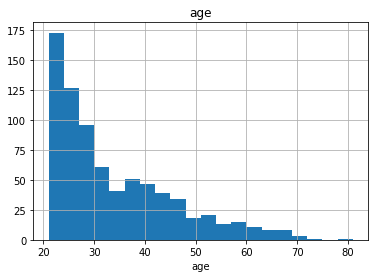

In [6]:
for col in num_cols:
    num_summary(df, col, plot=True)

<a id="5"> </a>
## Data Preparation

#### Outlier Analysis

Let's see  whether variables has outliers

In [7]:
for col in num_cols:
    print(f"{col} : {check_outlier(df,col)}")
    grab_outliers(df, col)

pregnancies : True
     pregnancies  glucose  bloodpressure  skinthickness  insulin    bmi  diabetespedigreefunction  age  outcome
88            15      136             70             32      110 37.100                     0.153   43        1
159           17      163             72             41      114 40.900                     0.817   47        1
298           14      100             78             25      184 36.600                     0.412   46        1
455           14      175             62             30        0 33.600                     0.212   38        1
glucose : True
     pregnancies  glucose  bloodpressure  skinthickness  insulin    bmi  diabetespedigreefunction  age  outcome
75             1        0             48             20        0 24.700                     0.140   22        0
182            1        0             74             20       23 27.700                     0.299   21        0
342            1        0             68             35        0 32.00

Alright,each variables have outliers

<a id="6"> </a>
## Missing Value Analysis

In [8]:
missing_values_table(df,True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

**As you can see,we don't have missing values,that's awesome for data scientist**

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
bloodpressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
skinthickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
bmi,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
diabetespedigreefunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


**However,When we have examined,we can see 0 values for Glucose,BloodPressure,SkinThickness,Insulin,BMI.These values don't be 0.Therefore,We have to edit these values.**

In [10]:
df.glucose=df.glucose.replace([0],float('NaN'))
df.bloodpressure=df.bloodpressure.replace([0],float('NaN'))
df.skinthickness=df.skinthickness.replace([0],float('NaN'))
df.insulin=df.insulin.replace([0],float('NaN'))
df.bmi=df.bmi.replace([0],float('NaN'))
missing_column=missing_values_table(df,True)

               n_miss  ratio
insulin           374 48.700
skinthickness     227 29.560
bloodpressure      35  4.560
bmi                11  1.430
glucose             5  0.650


<a id="7"> </a>
## Missing Value Processing

In [11]:
for column in missing_column:
    df.loc[(df["outcome"] == 0) & (df[column].isnull()), column] = df[df["outcome"] == 0][column].median()
    df.loc[(df["outcome"] == 1) & (df[column].isnull()), column] = df[df["outcome"] == 1][column].median()

In [12]:
missing_column = missing_values_table(df,True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


<a id="8"> </a>
## Outlier Processing

In [13]:
for col in num_cols:
    replace_with_thresholds(df, col)

Let's check whether outliers of variables one more time

In [14]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False
False
False
False
False


Now,We need to handle feature engineering,this section is my favourite stage

In [15]:
categories=["Very Low","Low","Avarage","High","Very High","Extreme High"]
age_cat=["Kid","Young","Adult","AvarageAged","Old"]

In [16]:
df["age_bmi_ratio"] =df.age/df.bmi
df["pregnancies_age_ratio"] = df.pregnancies/df.age
df["glucose_age_ratio"] = df.glucose/df.age
df["skinthickness_age_ratio"] = df.skinthickness/df.age
df["insulin_age_ratio"] = df.insulin/df.age
df["glocose_square"] = df.glucose**2
df["glocose_dot_insulin_sqaure"] = (df.glucose*df.insulin)**2
df["age_bmi_ratio_flag"]=pd.qcut(df["age_bmi_ratio"],len(categories),labels=categories)
df["glucose_age_ratio_flag"]=pd.qcut(df["glucose_age_ratio"],len(categories),labels=categories)
df["pregnancies_age_ratio_flag"] = pd.qcut(df['pregnancies_age_ratio'], len(categories) , labels=categories)
df["age_flag"] = pd.qcut(df['age'], len(age_cat), labels=age_cat)

In [17]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,age_bmi_ratio,pregnancies_age_ratio,glucose_age_ratio,skinthickness_age_ratio,insulin_age_ratio,glocose_square,glocose_dot_insulin_sqaure,age_bmi_ratio_flag,glucose_age_ratio_flag,pregnancies_age_ratio_flag,age_flag
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,1.488,0.120,2.960,0.700,3.390,21904.000,629307396.000,Extreme High,Low,High,Old
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,1.165,0.032,2.742,0.935,3.306,7225.000,75907656.250,Very High,Low,Low,Adult
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,1.373,0.250,5.719,1.000,5.297,33489.000,962147342.250,Very High,Extreme High,Extreme High,Adult
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0.747,0.048,4.238,1.095,4.476,7921.000,69989956.000,Low,High,Low,Kid
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,0.766,0.000,4.152,1.061,5.091,18769.000,529736256.000,Low,High,Very Low,Adult


<a id="9"> </a>
## Encoding

### Label Encoding

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)
df.head()

Observations: 768
Variables: 20
cat_cols: 5
num_cols: 15
cat_but_car: 0
num_but_cat: 5


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,age_bmi_ratio,pregnancies_age_ratio,glucose_age_ratio,skinthickness_age_ratio,insulin_age_ratio,glocose_square,glocose_dot_insulin_sqaure,age_bmi_ratio_flag_Low,age_bmi_ratio_flag_Avarage,age_bmi_ratio_flag_High,age_bmi_ratio_flag_Very High,age_bmi_ratio_flag_Extreme High,glucose_age_ratio_flag_Low,glucose_age_ratio_flag_Avarage,glucose_age_ratio_flag_High,glucose_age_ratio_flag_Very High,glucose_age_ratio_flag_Extreme High,pregnancies_age_ratio_flag_Low,pregnancies_age_ratio_flag_Avarage,pregnancies_age_ratio_flag_High,pregnancies_age_ratio_flag_Very High,pregnancies_age_ratio_flag_Extreme High,age_flag_Young,age_flag_Adult,age_flag_AvarageAged,age_flag_Old
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,1.488,0.120,2.960,0.700,3.390,21904.000,629307396.000,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,1.165,0.032,2.742,0.935,3.306,7225.000,75907656.250,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,1.373,0.250,5.719,1.000,5.297,33489.000,962147342.250,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0.747,0.048,4.238,1.095,4.476,7921.000,69989956.000,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,0.766,0.000,4.152,1.061,5.091,18769.000,529736256.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


<a id="10"> </a>
## Feature Scaling

In [19]:
transform_power = RobustScaler()
df[num_cols] = transform_power.fit_transform(df[num_cols])
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,age_bmi_ratio,pregnancies_age_ratio,glucose_age_ratio,skinthickness_age_ratio,insulin_age_ratio,glocose_square,glocose_dot_insulin_sqaure,age_bmi_ratio_flag_Low,age_bmi_ratio_flag_Avarage,age_bmi_ratio_flag_High,age_bmi_ratio_flag_Very High,age_bmi_ratio_flag_Extreme High,glucose_age_ratio_flag_Low,glucose_age_ratio_flag_Avarage,glucose_age_ratio_flag_High,glucose_age_ratio_flag_Very High,glucose_age_ratio_flag_Extreme High,pregnancies_age_ratio_flag_Low,pregnancies_age_ratio_flag_Avarage,pregnancies_age_ratio_flag_High,pregnancies_age_ratio_flag_Very High,pregnancies_age_ratio_flag_Extreme High,age_flag_Young,age_flag_Adult,age_flag_AvarageAged,age_flag_Old
0,0.600,0.765,0.000,1.000,1.000,0.170,0.665,1.235,1,1.089,0.198,-0.507,-0.400,-0.238,0.845,1.034,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,-0.400,-0.790,-0.375,0.143,0.000,-0.599,-0.056,0.118,0,0.422,-0.504,-0.633,0.060,-0.274,-0.665,-0.290,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1.000,1.630,-0.500,0.571,1.000,-0.962,0.783,0.176,1,0.852,1.238,1.084,0.186,0.584,2.037,1.830,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
3,-0.400,-0.691,-0.375,-0.714,-0.127,-0.434,-0.537,-0.471,0,-0.442,-0.381,0.230,0.372,0.230,-0.593,-0.304,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,-0.600,0.494,-2.000,1.000,0.978,1.214,2.163,0.235,1,-0.405,-0.762,0.180,0.304,0.495,0.523,0.796,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


<a id="11"></a>
# Modeling

In [20]:
#preparation of the data

y = df.outcome
X = df.drop('outcome', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

<a id="41"></a>
## Selection of the best models

I will compare different algorithm using [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). <br>
K-fold is important here (in the case of a small dataset) because it enables us to train/test the model 10 times and then we can reduce the chance of over-fitting or even luck.
The models tried for this bi-label classification problem will be:
- Logistic Regression
- Decision Tree
- Random Forest
- SVM
- ExtraTree
- Gradient Boosting
- AdaBoost
- KNN 
- XGBoost
- Light GBM

In [21]:
models = list()

#here is the list of the models we'll try 

models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(SVC())
models.append(NuSVC())
models.append(CalibratedClassifierCV())
models.append(LinearSVC())
models.append(lgbm.LGBMClassifier())
models.append(ExtraTreesClassifier())
models.append(GradientBoostingClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1))
models.append(KNeighborsClassifier())
models.append(XGBClassifier())

In [22]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

In [23]:
def show_values(axs, orient="v", space=0.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.5)
                value = '{:.5f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.5f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

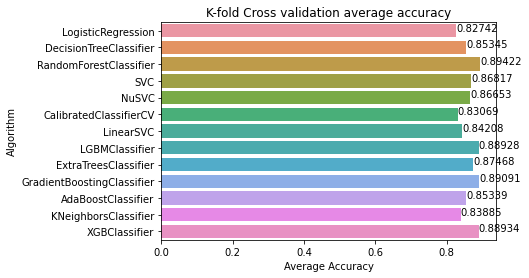

In [24]:
cv_results = []
cv_names = []

for model in models :
    #print('go:', model)
    cv_results.append(cross_val_score(model, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))
    cv_names.append(model.__class__.__name__)
    #print('end:', model)
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":cv_names})
g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res,ci=None)
g.set_xlabel("Average Accuracy")
g.set_title("K-fold Cross validation average accuracy")
show_values(g,"h",space=0.0005)


    

The different algorithm performs differently. We need to look at the average, but also at the standard deviation of the accuracy of these algorithms. Indeed, we want our model to perform well on average, but we don't want it to perform really poorly sometimes or really greatly on other times. <br>
I decided to use a hand-crafted criterion in order to take into account both average and deviation. The criterion is defined as the average minus the half of the deviation. So we take the algorithm with the best accuracy modulated by a not to big deviation. 

In [25]:
cv_res['criterion'] = cv_res.CrossValMeans - cv_res.CrossValerrors/2

In [27]:
cv_res.sort_values(by='criterion', ascending=False).reset_index()

,index,CrossValMeans,CrossValerrors,Algorithm,criterion
0,2,0.894,0.038,RandomForestClassifier,0.875
1,9,0.891,0.033,GradientBoostingClassifier,0.874
2,7,0.889,0.036,LGBMClassifier,0.871
3,12,0.889,0.045,XGBClassifier,0.867
4,8,0.875,0.045,ExtraTreesClassifier,0.852
5,3,0.868,0.039,SVC,0.849
6,4,0.867,0.037,NuSVC,0.848
7,1,0.853,0.032,DecisionTreeClassifier,0.837
8,10,0.853,0.035,AdaBoostClassifier,0.836
9,6,0.842,0.042,LinearSVC,0.821


Gradient Boosting produces the best outcome in terms of criterion. We can directly use it to produce the submission file. <br>
Or we can decide to use different models and ensemble the results in order to produce a better outcome: this method is so-called 'Ensemble modeling'.<br>
To select the best ones, I use a criterion which is the mean of the accuracy minus the half of the standard deviation of the accuracy. <br>
But first, let's select the 5 best algorithms in order to perform hyper-parameters optimization:
- GradientBoosting
- XGBoost
- LGBM
- RandomForest
- Extra Tree

<a id="12"></a>
## Hyper-parameter optimization

In this part, I try to improve the accuracy of the selected classifiers by hyper-parameters optimization. To do so, I use a Scikit-Learn implemented tool in order to perform a grid search. 

Watch-out: This is a long process, you can use multi-cpu to speed-up the computation.

In [28]:
# Extra Trees Parameters tunning
ETC = ExtraTreesClassifier()
# Number of trees in extra tree
n_estimators=[int(x) for x in np.linspace(start = 200, stop = 400, num = 3)]

criterion=["gini","entropy"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20,2)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Number of features to consider at every split
max_features = ["auto", "sqrt","log2"]

etc_param_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": criterion}

gsETC = GridSearchCV(ETC,param_grid = etc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsETC.fit(X_train,y_train)

ETC_best = gsETC.best_estimator_

print(ETC_best.get_params())
# Best score
gsETC.best_score_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


0.8811808609889379

In [29]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 21,3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

## Search grid for optimal parameters
rf_param_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": ["gini","entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)
 
RFC_best = gsRFC.best_estimator_

print(RFC_best.get_params())


# Best score
gsRFC.best_score_

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 21, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 333, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


0.900719712115154

In [30]:
# Gradient boosting tunning


#shrinks the contribution of each tree by learning_rate.
learning_rates = [1, 0.25, 0.05]
#the number of trees in the forest
n_estimators = [1, 2, 4,  32]
# how deep the built tree can be
max_depths = np.linspace(1, 32, 4, endpoint=True)

#minimum number of samples required to be at a leaf node.
min_samples_leafs =  np.linspace(0.1, 0.5, 4, endpoint=True)
#represents the number of features to consider when looking for the best split
max_features = [0.3, 0.1]

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : n_estimators,
              'learning_rate': learning_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leafs,
              'max_features': max_features
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

print(GBC_best.get_params())


# Best score
gsGBC.best_score_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 11.333333333333334, 'max_features': 0.3, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 32, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


0.8974676795948288

In [31]:
### LGBM regressor
lgbm_model =lgbm.LGBMClassifier()

n_estimators = [0.1, 1, 10, 50, 100]
min_data_leaf = np.linspace(10,40,5)
# how deep the built tree can be
max_depths = np.linspace(1, 32, 4, endpoint=True)

lgbm_param_grid = {
     'colsample_bytree': [0.4,0.6,1],
    'learning_rate': [0.01, 0.1,1],
    'n_estimators': [20, 40, 100],
    'max_depth': [1,2,4,8]
                 }

gsLGBM = GridSearchCV(lgbm_model,param_grid = lgbm_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsLGBM.fit(X_train,y_train)

LGBM_best = gsLGBM.best_estimator_

print(LGBM_best.get_params())


# Best score
gsLGBM.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.4, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 40, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


0.9105024656803945

In [32]:
gsLGBM.best_estimator_

LGBMClassifier(colsample_bytree=0.4, max_depth=8, n_estimators=40)

In [33]:
gsLGBM.best_score_

0.9105024656803945

In [35]:
### XGB classifier

XGB = XGBClassifier()



max_depth = [1,2,4]
min_child_weight = np.linspace(1, 9, 3, endpoint=True) 

gamma = np.linspace(0.5, 3, 3, endpoint=True)
subsample = np.linspace(0.5, 3, 3, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, 3, endpoint=True)

XGB_param_grid = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth
        }


gsXGB = GridSearchCV(estimator = XGB, 
                    param_grid = XGB_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsXGB.fit(X_train,y_train)

XGB_best = gsXGB.best_estimator_
print(XGB_best.get_params())

# Best score
gsXGB.best_score_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[21:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'enable_categorical': False, 'gamma': 1.75, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1.0, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact', 'valid

0.9023590563774491

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[21:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'enable_categorical': False, 'gamma': 1.75, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1.0, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact', 'valid

0.9023590563774491

<a id="13"></a>
## Ensemble Modeling 

<AxesSubplot:>

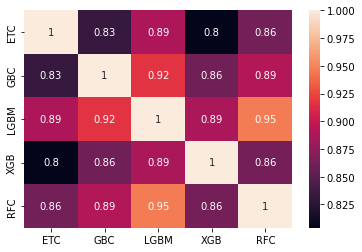

In [36]:
test_Survived_ETC = pd.Series(ETC_best.predict(X_test), name="ETC")
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")
test_Survived_LGBM = pd.Series(LGBM_best.predict(X_test), name="LGBM")
test_Survived_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_ETC,test_Survived_GBC,test_Survived_LGBM, test_Survived_XGB, test_Survived_RFC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)
g

In [37]:
print('test score ETC:', gsETC.best_score_)
print('test score RFC:', gsRFC.best_score_)
print('test score GBC:', gsGBC.best_score_)
print('test score LGBM:', gsLGBM.best_score_)
print('test score XGB:', gsXGB.best_score_)

test score ETC: 0.8811808609889379
test score RFC: 0.900719712115154
test score GBC: 0.8974676795948288
test score LGBM: 0.9105024656803945
test score XGB: 0.9023590563774491


The classifier are quiet correlated. This is a good sign! However we observe some differences between the 5 classifiers. This is good for you because we can leverage the use of a voting system to improve our prediction.

In [38]:
#here I use the soft rule as voting rule because it produced a better score on Kaggle rather than the hard rule. 
classifier=[('ETC', ETC_best),('GBC', GBC_best), ('LGBM',LGBM_best), ('XGB',XGB_best), ("RandomForest",RFC_best)]
votingC = VotingClassifier(estimators=classifier, voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)

<a id="14"></a>
# Submission

In [39]:
test_outcome = pd.Series(votingC.predict(X_test), name="outcome")

In [40]:
predictions = votingC.predict(X_test)
output = pd.DataFrame({'Outcome': predictions })
output.to_csv('diabete-predictions.csv', index = False)
output

,Outcome
0,1
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,0
